## Score Clustering


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

In [3]:
# filter by political subreddits

# read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]
print(political_subs[:20])

# filter dataframe 
source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

df = df_full[source_is_political & target_is_political]

['2012Elections', '2016Elections', '2016_elections', '2ALiberals', 'AOC', 'Abortiondebate', 'ActiveMeasures', 'AgainstHateSubreddits', 'AgainstTheChimpire', 'Agorism', 'Albertapolitics', 'AlexandriaOcasio', 'AltRightChristian', 'AmalaNetwork', 'AmericanPolitics', 'AnCap101', 'Anarchism', 'AnarchismOnline', 'AnarchistNews', 'Anarcho_Capitalism']


In [4]:
df.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
547,communism101,communism,1ujok7s,2014-01-06 08:44:10,1,"608.0,525.0,0.792763157895,0.00164473684211,0...."
2256,communism101,socialism,1vi0kys,2014-01-17 13:25:07,1,"2073.0,1792.0,0.766039556199,0.0284611673903,0..."
3904,communism101,communism,1wfqzgs,2014-01-28 17:23:01,1,"4807.0,4078.0,0.793634283337,0.00312044934471,..."
5288,mmt_economics,ronpaul,1x7538s,2014-02-06 07:42:09,1,"2939.0,2452.0,0.793126913916,0.00442327322218,..."
7143,askaconservative,politics,1y90oks,2014-02-18 13:18:36,1,"599.0,511.0,0.779632721202,0.00500834724541,0...."


In [5]:
# Create the adjacency matrix from the filtered DataFrame
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# create graph
G = nx.from_pandas_edgelist(edgelist_df, source=source, target=target, create_using=nx.DiGraph(),edge_attr="count")
# convert to adjacency matrix
adj_matrix = nx.to_pandas_adjacency(G, weight="count")

In [27]:
adj_matrix

,communism101,communism,socialism,mmt_economics,ronpaul,askaconservative,politics,alltheleft,altnewz,agitation,...,shitleftistssay,uspolitics,justicedemocrats,shitguncontrollerssay,daverubin,thedavidpakmanshow,neoliberal,holocaust,esist,georgism
communism101,0.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
communism,5.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
socialism,5.0,6.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mmt_economics,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ronpaul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
thedavidpakmanshow,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
neoliberal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
holocaust,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
esist,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculate the Laplacian matrix and the k eigenvectors of the Laplacian (here using 10)

In [ ]:
# compute the normalized Laplacian matrix
laplacian_matrix = laplacian(adj_matrix.values, normed=True)  

# get eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(laplacian_matrix)
max_k = 10
selected_eigenvectors = eigenvectors[:, 1:max_k+1]

# compute ratios of eigenvectors (epsilon makes sure we don't divide by 0)
epsilon = 1e-10  
denominator = selected_eigenvectors[:, [0]].copy()
denominator[np.abs(denominator) < epsilon] = epsilon 
ratios = selected_eigenvectors / denominator

Apply K-Means clustering for k=1:10

In [14]:
k_values = range(1, 11)  # Start from k=1
inertia_values = []
silhouette_scores = []

# Perform K-Means for k=1 to k=10 and store inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(ratios)  # Use the computed ratios from eigenvectors
    
    # Inertia for all k
    inertia_values.append(kmeans.inertia_)
    
    # Silhouette score only for k >= 2
    if k > 1:
        score = silhouette_score(ratios, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan)  # Placeholder for k=1 (silhouette is undefined)


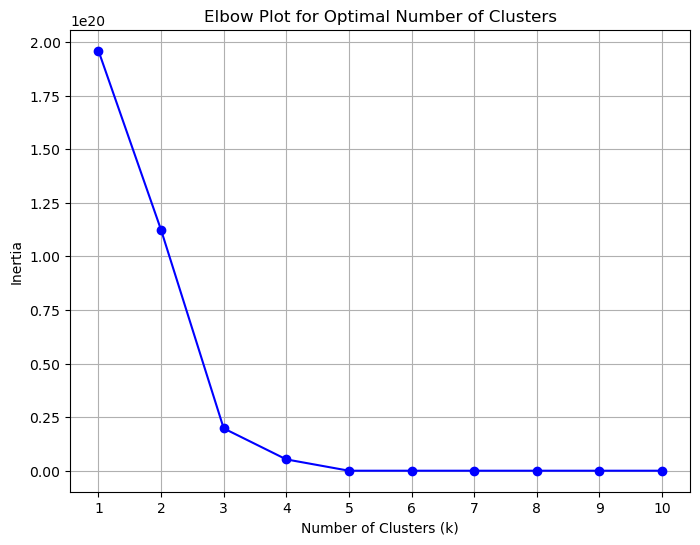

In [40]:
# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.title("Elbow Plot for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid(True)
plt.show()

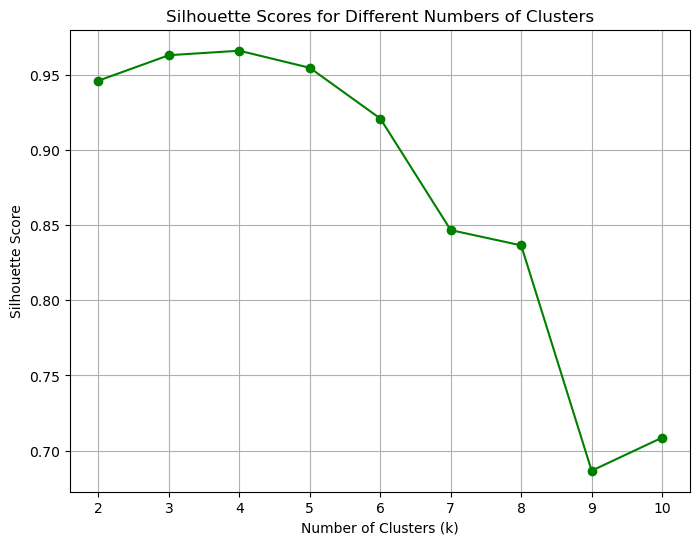

In [41]:
# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values[1:], silhouette_scores[1:], marker='o', linestyle='-', color='g') # silhouette score doesn't exist for k=1
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values[1:])
plt.grid(True)
plt.show()

Perform k-means clustering on the ratio of eigenvectors using the best k identified from the plots (3)

In [ ]:
# best the number of clusters (k)
k = 3

selected_eigenvectors = eigenvectors[:, 1:k+1]

epsilon = 1e-10  
denominator = selected_eigenvectors[:, [0]].copy()
denominator[np.abs(denominator) < epsilon] = epsilon 
ratios = selected_eigenvectors / denominator

In [42]:
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(selected_eigenvectors)

# assign cluster labels to subreddits
clustered_subreddits = pd.DataFrame({
    "Subreddit": adj_matrix.index,
    "Cluster": clusters
})

In [45]:
# print subreddits in each cluster
for cluster_id in range(k):
    print(f"Cluster {cluster_id}:")
    subreddits_in_cluster = clustered_subreddits[clustered_subreddits["Cluster"] == cluster_id]["Subreddit"]
    print(", ".join(subreddits_in_cluster))
    print("\n")

Cluster 0:
mmt_economics, ronpaul, askaconservative, politics, altnewz, agitation, worldpolitics, badeconomics, progressive, prochoice, prolife, syriancivilwar, badpolitics, ukipparty, ukpolitics, futuristparty, restorethefourth, gunpolitics, randpaul, progun, geopolitics, censorship, anarchocommunism, metanarchism, new_right, democrats, worldevents, law, scotus, enoughsandersspam, climateskeptics, exlibertarian, politicalfactchecking, moderatepolitics, inthenews, economy, libertarianmeme, trump16, socialanarchism, rojava, iranpolitics, europeans, hillaryclinton, media_criticism, chomsky, donaldtrump, distributism, fullstalinism, jillstein, askhillarysupporters, occupywallstreet, brexit, liberalgunowners, guncontrol, samharris, 2016_elections, slatestarcodex, abetterworldnews, foreignpolicy, neutralnews, communists, altright, terrorism, the_meltdown, calexit, militant, mormonpolitics, thenewcoldwar, demsocialist, acteuropa, shitleftistssay, uspolitics, justicedemocrats, shitguncontroll

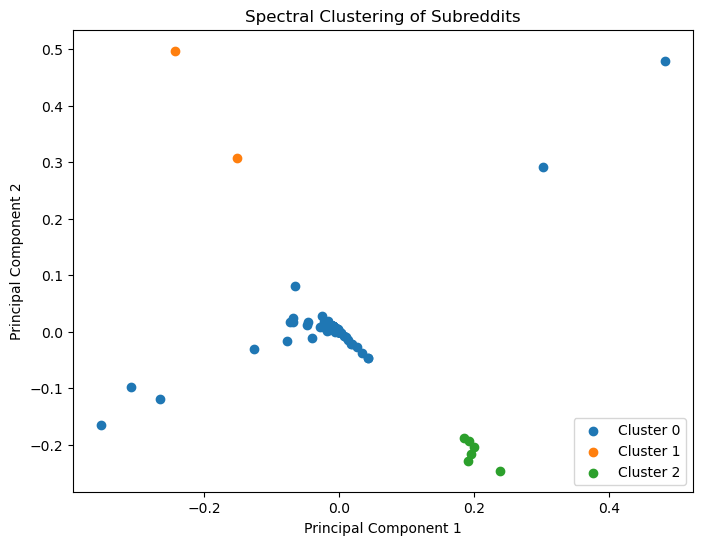

In [38]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(selected_eigenvectors)

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in range(k):
    plt.scatter(reduced_data[clusters == cluster, 0],
                reduced_data[clusters == cluster, 1], label=f"Cluster {cluster}")
plt.title("Spectral Clustering of Subreddits")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()